In [1]:
%matplotlib inline
import os
from common.plot_fcns import get_env_var
import cPickle as pkl
import numpy as np
import pandas as pd
import colorsys
import matplotlib.colors as mc
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import pylab
import matplotlib.patheffects as path_effects
import seaborn as sns
from sklearn.metrics import accuracy_score,f1_score, confusion_matrix, r2_score, precision_recall_fscore_support
import common.metrics as met
import common.plots as plo
from common.h5py_loading import load_target_map, load_dataset
from common.h5py_data_loader import H5pyDataLoader
from common.prediction_analysis import df_from_chembl_export, intersect_truth_prediction
from lasagne_nn.run_nn import get_predictions_of_knowns, get_network_from_weights
from lasagne_nn.output_loader import df_from_prediction_path

/srv/home/ecaceres/anaconda2/envs/features/lib/python2.7/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)
ERROR (theano.gpuarray): Could not initialize pygpu, support disabled
Traceback (most recent call last):
  File "/srv/home/ecaceres/anaconda2/envs/features/lib/python2.7/site-packages/theano/gpuarray/__init__.py", line 227, in <module>
    use(config.device)
  File "/srv/home/ecaceres/anaconda2/envs/features/lib/python2.7/site-packages/theano/gpuarray/__init__.py", line 214, in use
    init_dev(device, preallocate=preallocate)
  File "/srv/home/ecaceres/anaconda2/envs/features/lib/python2.7/site-packages/theano/gpuarray/__init__.py", line 99, in init_dev
    **args)
  File "pygpu/gpuarray.pyx", line 658, in pygpu.gpuarray.init
  File 

In [2]:
expt_color_lookup = {
"NEG_RM": "NEG_RM",
"STD": "STD",
"NEG_RM_SMA": "NEG_RM_SMA",
'NEG_RM_RATIOS': "NEG_RM_SMA",
"STD_SMA": "STD_SMA",
"scrambled_idx": "scrambled_idx",
"scrambled_idx_LC": "scrambled_idx",
"SEA_SMA": "SEA_SMA",
"scrambled_idx_no_SMA": "scrambled_idx_no_SMA",
"scrambled_idx_no_SMA_LC": "scrambled_idx_no_SMA",
"CLASSIFIER_SEA_SMA": "SEA_SMA",
"CLASSIFIER_NEG_RM_SMA_RATIOS":  "NEG_RM_SMA",
"CLASSIFIER_SMA_RATIOS": "STD_SMA",
"CLASSIFIER_scrambled_idx_LC": "scrambled_idx",
"CLASSIFIER_scrambled_idx_No_SMA_LC": "scrambled_idx_no_SMA",
"CLASSIFIER_STD": "STD", 
"NEG_RM_scrambled": "NEG_UW", 
"NEG_RM_RATIOS_scrambled": "SEA_SMA",
'CLASSIFIER_NEG_RM_scrambled' : "NEG_UW",
'CLASSIFIER_NEG_RM_RATIOS_scrambled': "SEA_SMA",
'CLASSIFIER_NEG_RM': 'NEG_RM',
"NEG_UW": "NEG_UW"}

expt_legend_lookup = {
"NEG_RM": "Negatives Removed",
"NEG_UW" : "Negatives Upweighted",
"STD": "STD",
"NEG_RM_SMA": "Negatives Removed +SNA",
"STD_SMA": "SNA",
"scrambled_idx_LC": "SNA scrambled",
"SEA_SMA": "SNA +SEA blacklist",
"scrambled_idx_no_SMA_LC": "STD scrambled",
"CLASSIFIER_SEA_SMA": "SNA +SEA blacklist (classifier)",
"CLASSIFIER_NEG_RM_SMA_RATIOS":  "Negatives Removed +SNA (classifier)",
"CLASSIFIER_SMA_RATIOS": "SNA (classifier)",
"CLASSIFIER_scrambled_idx_LC": "SNA scrambled (classifier)",
"CLASSIFIER_scrambled_idx_No_SMA_LC": "STD scrambled (classifier)",
"CLASSIFIER_STD": "STD (classifier)", 
"NEG_RM_scrambled": "Negatives Removed scrambled", 
"NEG_RM_RATIOS_scrambled": "Negatives Removed +SNA scrambled",
'CLASSIFIER_NEG_RM_scrambled' : "Negatives Removed scrambled (classifier)",
'CLASSIFIER_NEG_RM_RATIOS_scrambled': "Negatives Removed +SNA scrambled (classifier)",
'CLASSIFIER_NEG_RM': 'Negatives Removed (classifier)', 
'CLASSIFIER_SEA_SMA': 'SNA +SEA blacklist (classifier)'}

In [3]:
# data handling

def get_preds(dset_dict, expt, dset, fold, ratio=None):
    indir = data_dict[expt]["indir"]
    if ratio is not None:
        knowns_file = data_dict[expt]["knowns_fmt"].format(indir, ratio, dset, fold)
        preds_file = data_dict[expt]["preds_fmt"].format(indir, ratio, dset, fold)
    else:
        knowns_file = data_dict[expt]["knowns_fmt"].format(indir, dset, fold)
        preds_file = data_dict[expt]["preds_fmt"].format(indir, dset, fold)
        
    prediction = np.load(preds_file)
    truth = np.load(knowns_file)
    
    if dset_dict[expt]["npz_fmt"] == True:
        prediction = prediction["arr_0"]
        truth = truth["arr_0"]
    return prediction, truth

In [4]:
def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    
    Credit: Ian Hincks from https://stackoverflow.com/questions/37765197/darken-or-lighten-a-color-in-matplotlib
    """
    try:
        c = mc.cnames[color]
    except:
        c = color

    c = colorsys.rgb_to_hls(*mc.colorConverter.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

In [5]:
def rename_vals(df, expt_lookup_dict=expt_legend_lookup):
    # rename expts
    if expt_lookup_dict: 
        df.expt=df.expt.map(expt_lookup_dict)
    # and dsets
    df.dset[df.dset == "drugmatrix"] = "Drug Matrix"
    df.dset[df.dset == "timesplit"] = "Time Split"
    df.dset[df.dset == "test"] = "Test"
    df.dset[df.dset == "train"] = "Train" 
    return df

In [6]:
reg_data_file = "./regression_preds_file_lookup.pkl"
with open(reg_data_file, "rb") as f:
    data_dict = pkl.load(f)

In [7]:
with open("./color_dict_pt.pkl", "rb") as f: 
    color_dict_pt = pkl.load(f)
with open("./color_dict_bar.pkl", "rb") as f: 
    color_dict_bar = pkl.load(f)

In [8]:
plot_data_save_base = "{}/20190410_SMA_Investigation/plot_data/regression".format(get_env_var("DATA_SAVE_BASE"))

In [9]:
df = pd.DataFrame(columns=["expt", "dset", "fold", "ratio", "AUROC", "AUPRC", "R2"])
data_dict.keys()
ratio_val = "1.0"
thresh=5.0
expts = data_dict.keys()
remake_data = False

if remake_data:
    for expt in expts:
        ratio_explicit = data_dict[expt]["ratios"]
        ratio = None if not ratio_explicit else ratio_val
        for dset in ["drugmatrix", "timesplit", "test", "train"]:
            for fold in np.arange(0,5,1):
                prediction, truth = get_preds(data_dict, expt, dset, fold, ratio=ratio)

                if dset != "drugmatrix":
                    known_mask = ~np.isnan(truth)
                    truth = truth[known_mask]
                    prediction = prediction[known_mask]

                auroc, _, _, _, _ = met.compute_binary_auc(prediction, truth, 
                                                               threshold=thresh, x_y_type="tpr-fpr")
                auprc, _, _, _, _ = met.compute_binary_auc(prediction, truth, 
                                                               threshold=thresh, x_y_type="precision-recall")
                if dset == "drugmatrix":
                    known_mask = ~np.isnan(truth)
                    truth = truth[known_mask]
                    prediction = prediction[known_mask]

                r2 = met.compute_rsquared(prediction, truth)
                
                input_data={"expt":[expt],"dset" :[dset], "fold": [fold], "ratio":[ratio_val], "AUROC":[auroc], 
                            "AUPRC":[auprc], "R2":[r2]}
                df = pd.concat([df, pd.DataFrame(input_data)], sort=False)

    df.to_csv("{}/neighbors_plot_vals.tsv".format(plot_data_save_base), sep='\t')

In [10]:
df = pd.read_csv("{}/neighbors_plot_vals.tsv".format(plot_data_save_base), sep="\t", index_col=0)

In [11]:
old_df = df.copy()

In [12]:
df = df.drop("ratio", axis=1)
save_dir = "{}/final_paper_figs".format(get_env_var("HOME"))

In [17]:
titlesize=40
labelsize=35

/srv/home/ecaceres/anaconda2/envs/features/lib/python2.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/srv/home/ecaceres/anaconda2/envs/features/lib/python2.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/srv/home/ecaceres/anaconda2/envs/features/lib/python2.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/srv/home/ecaceres/anaconda2/envs/features/lib/pyth

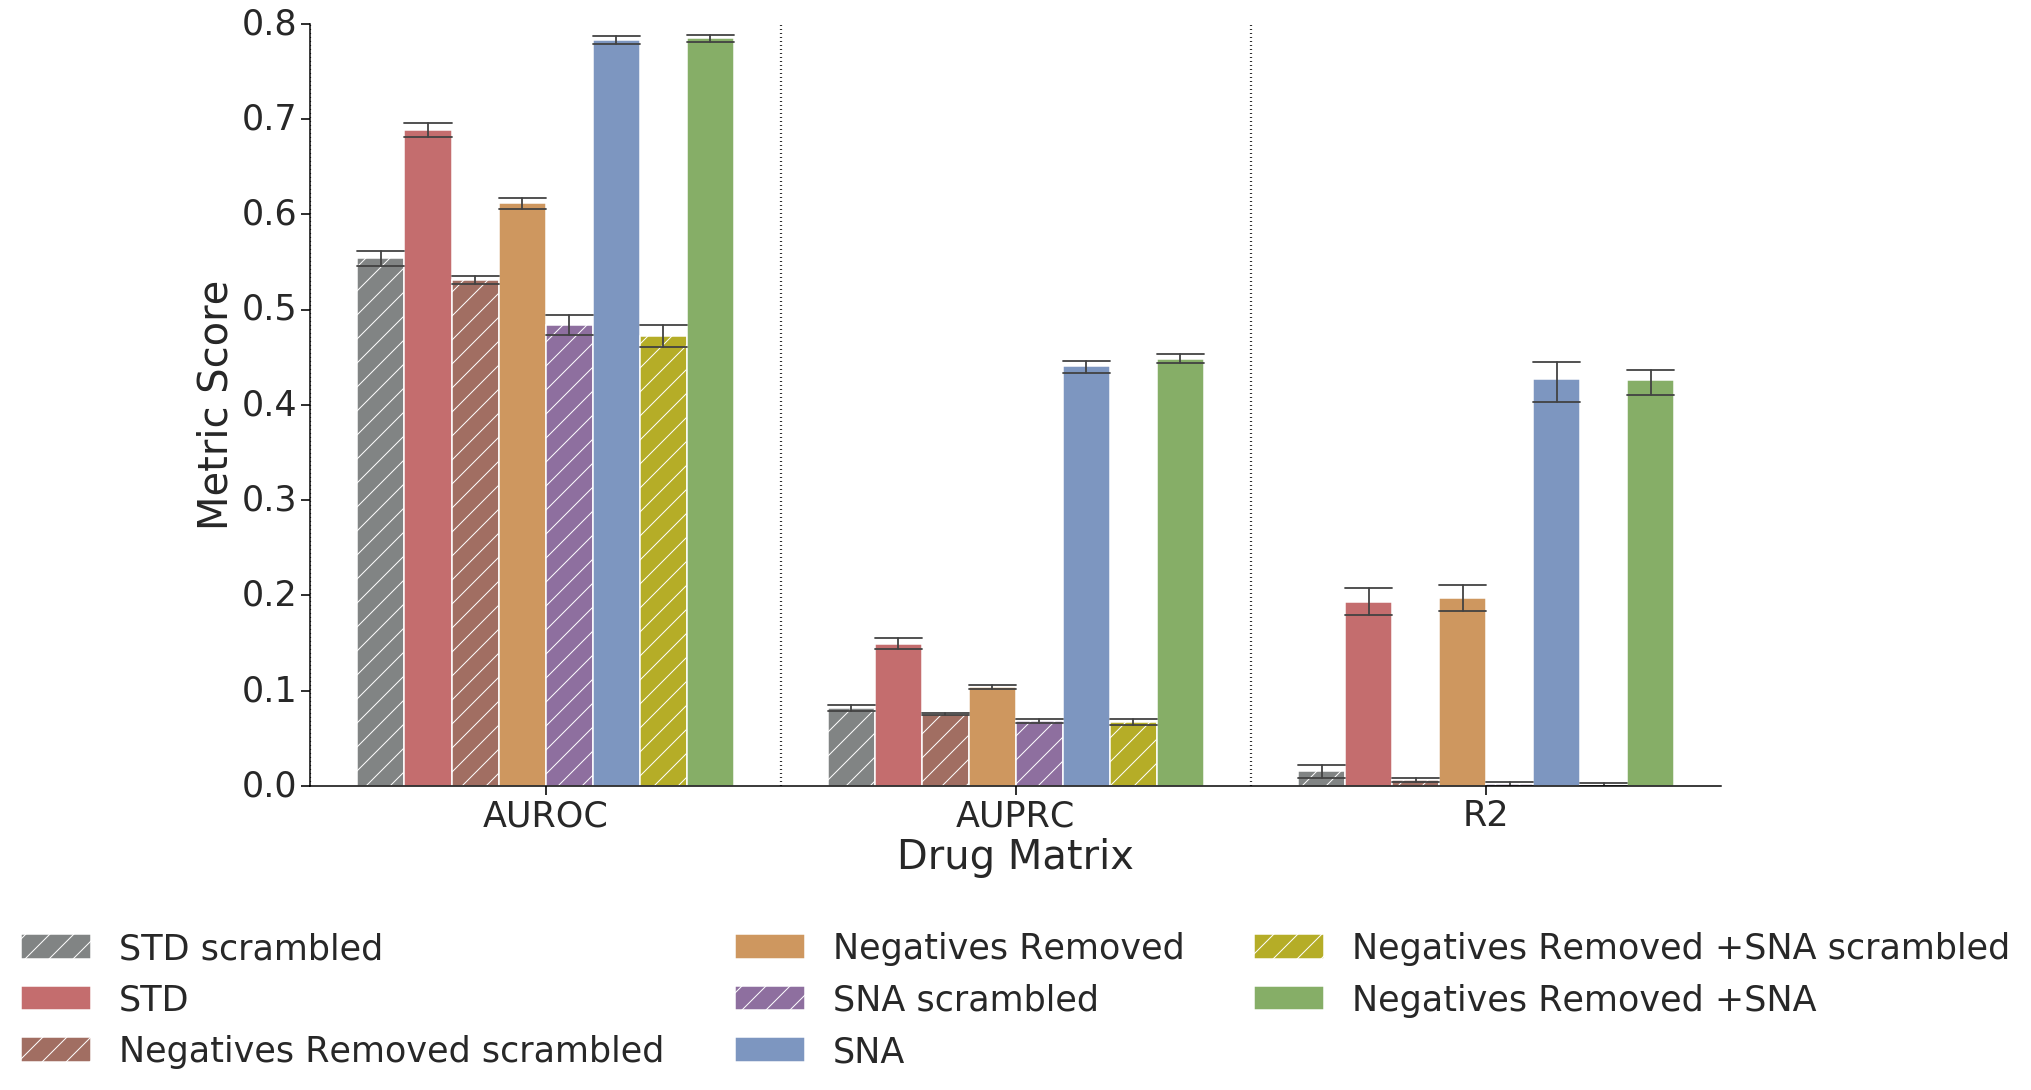

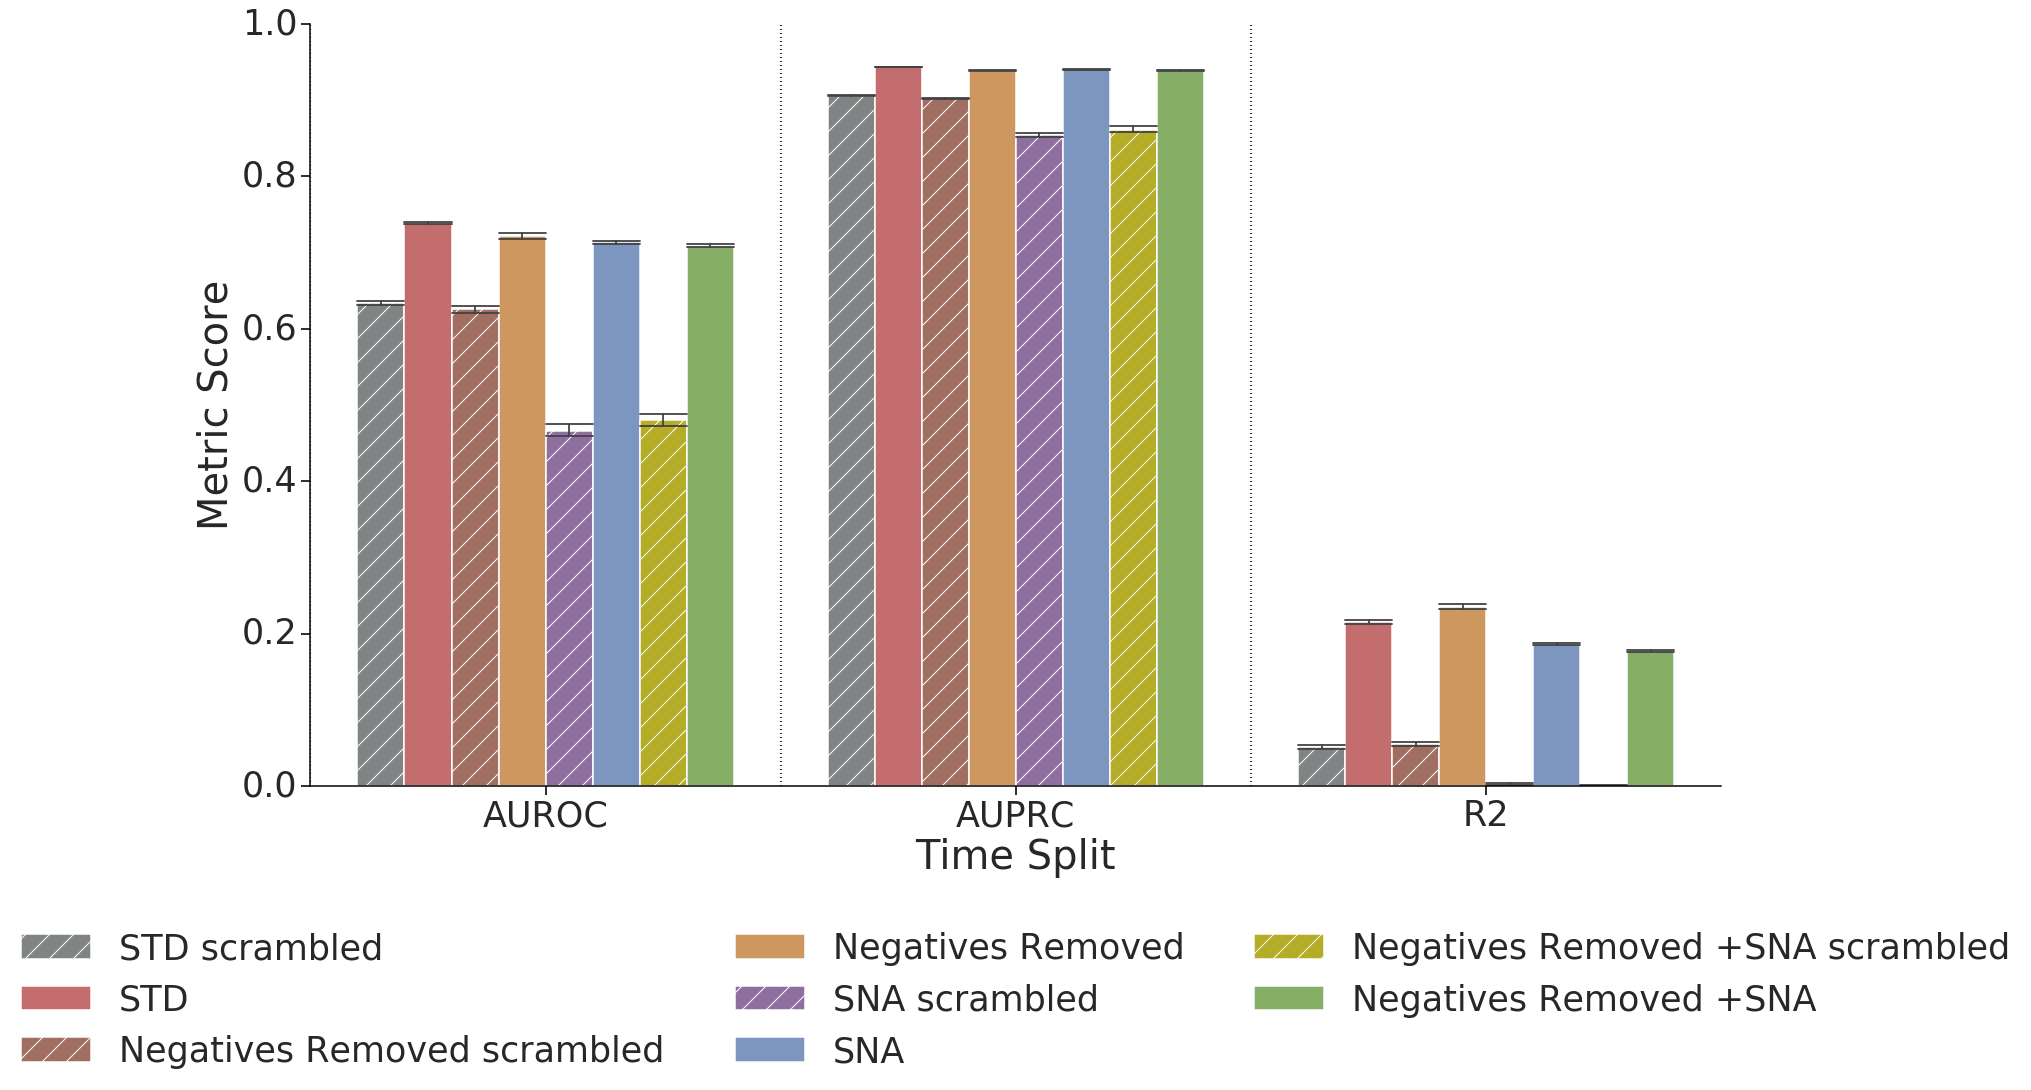

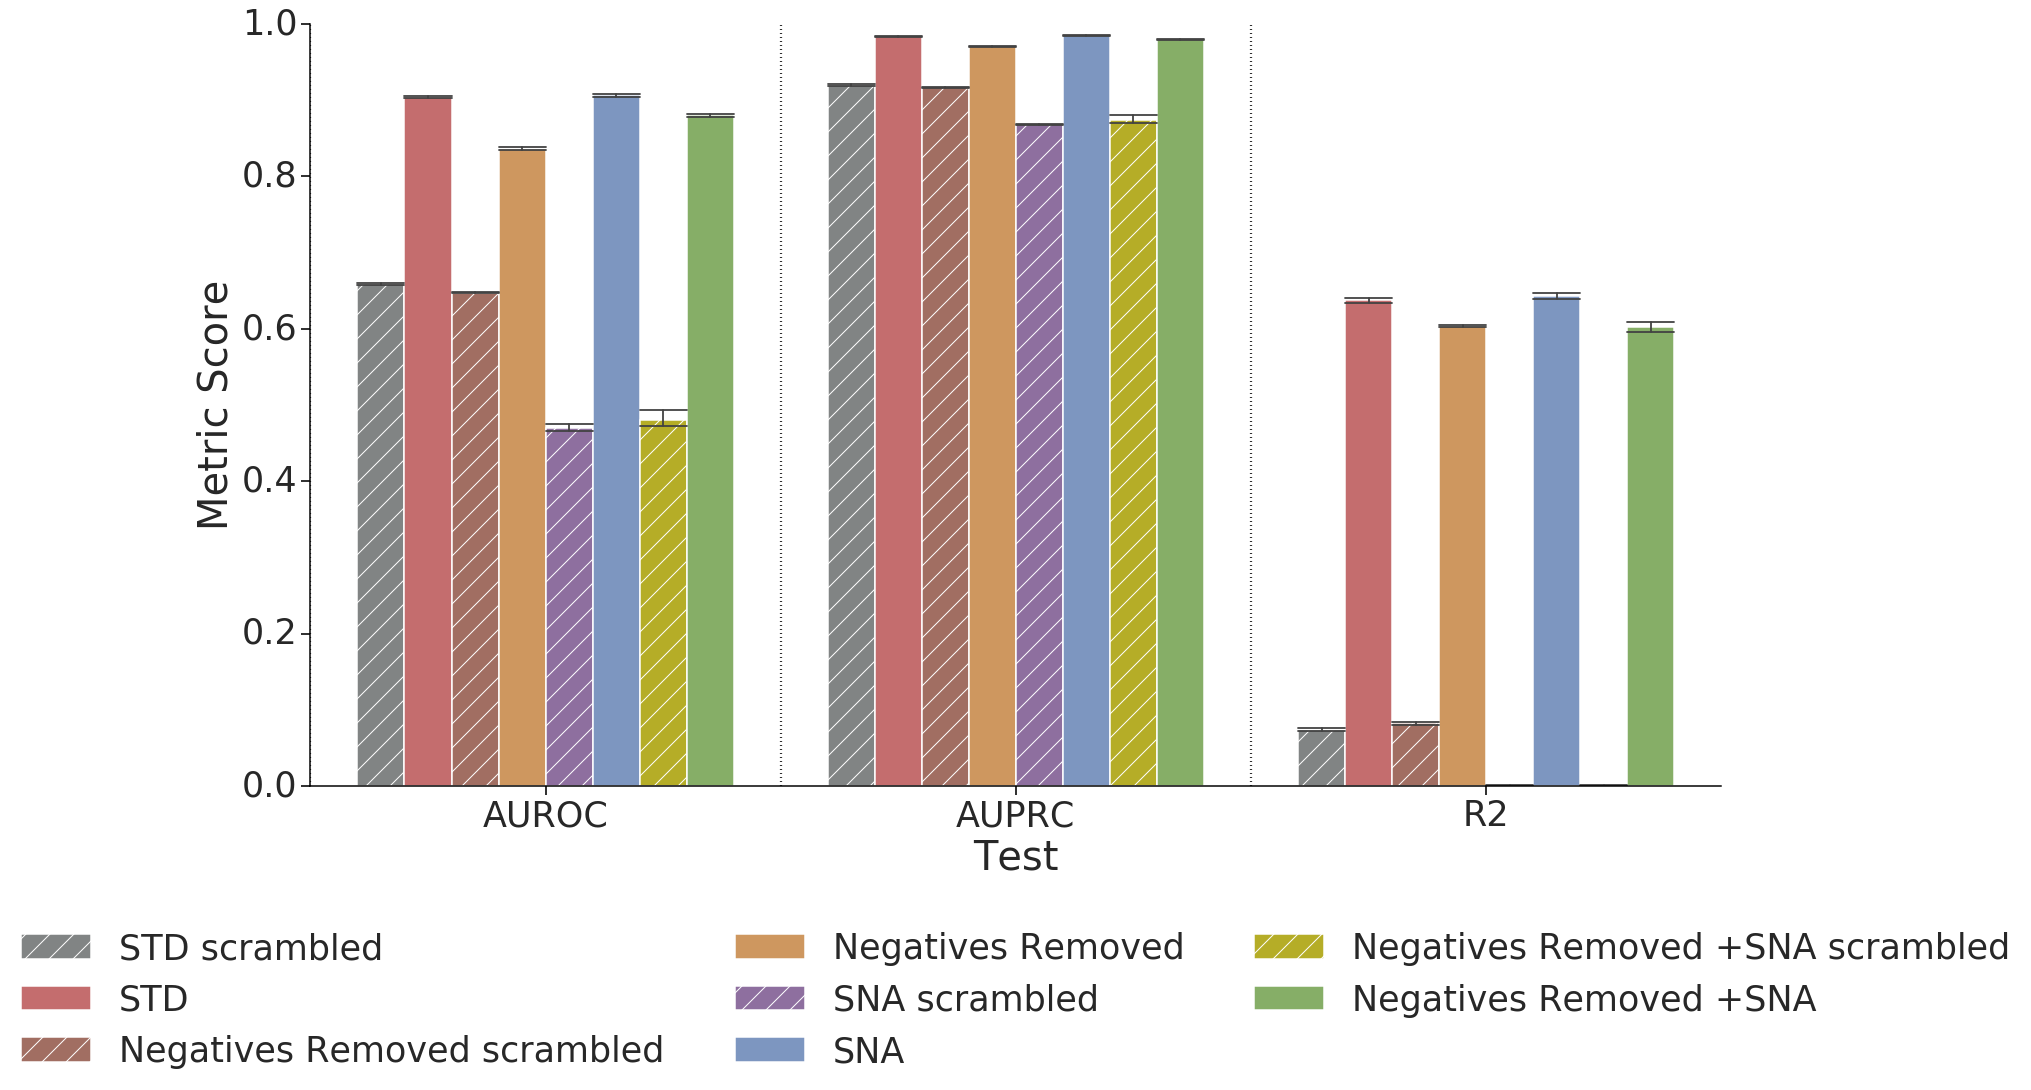

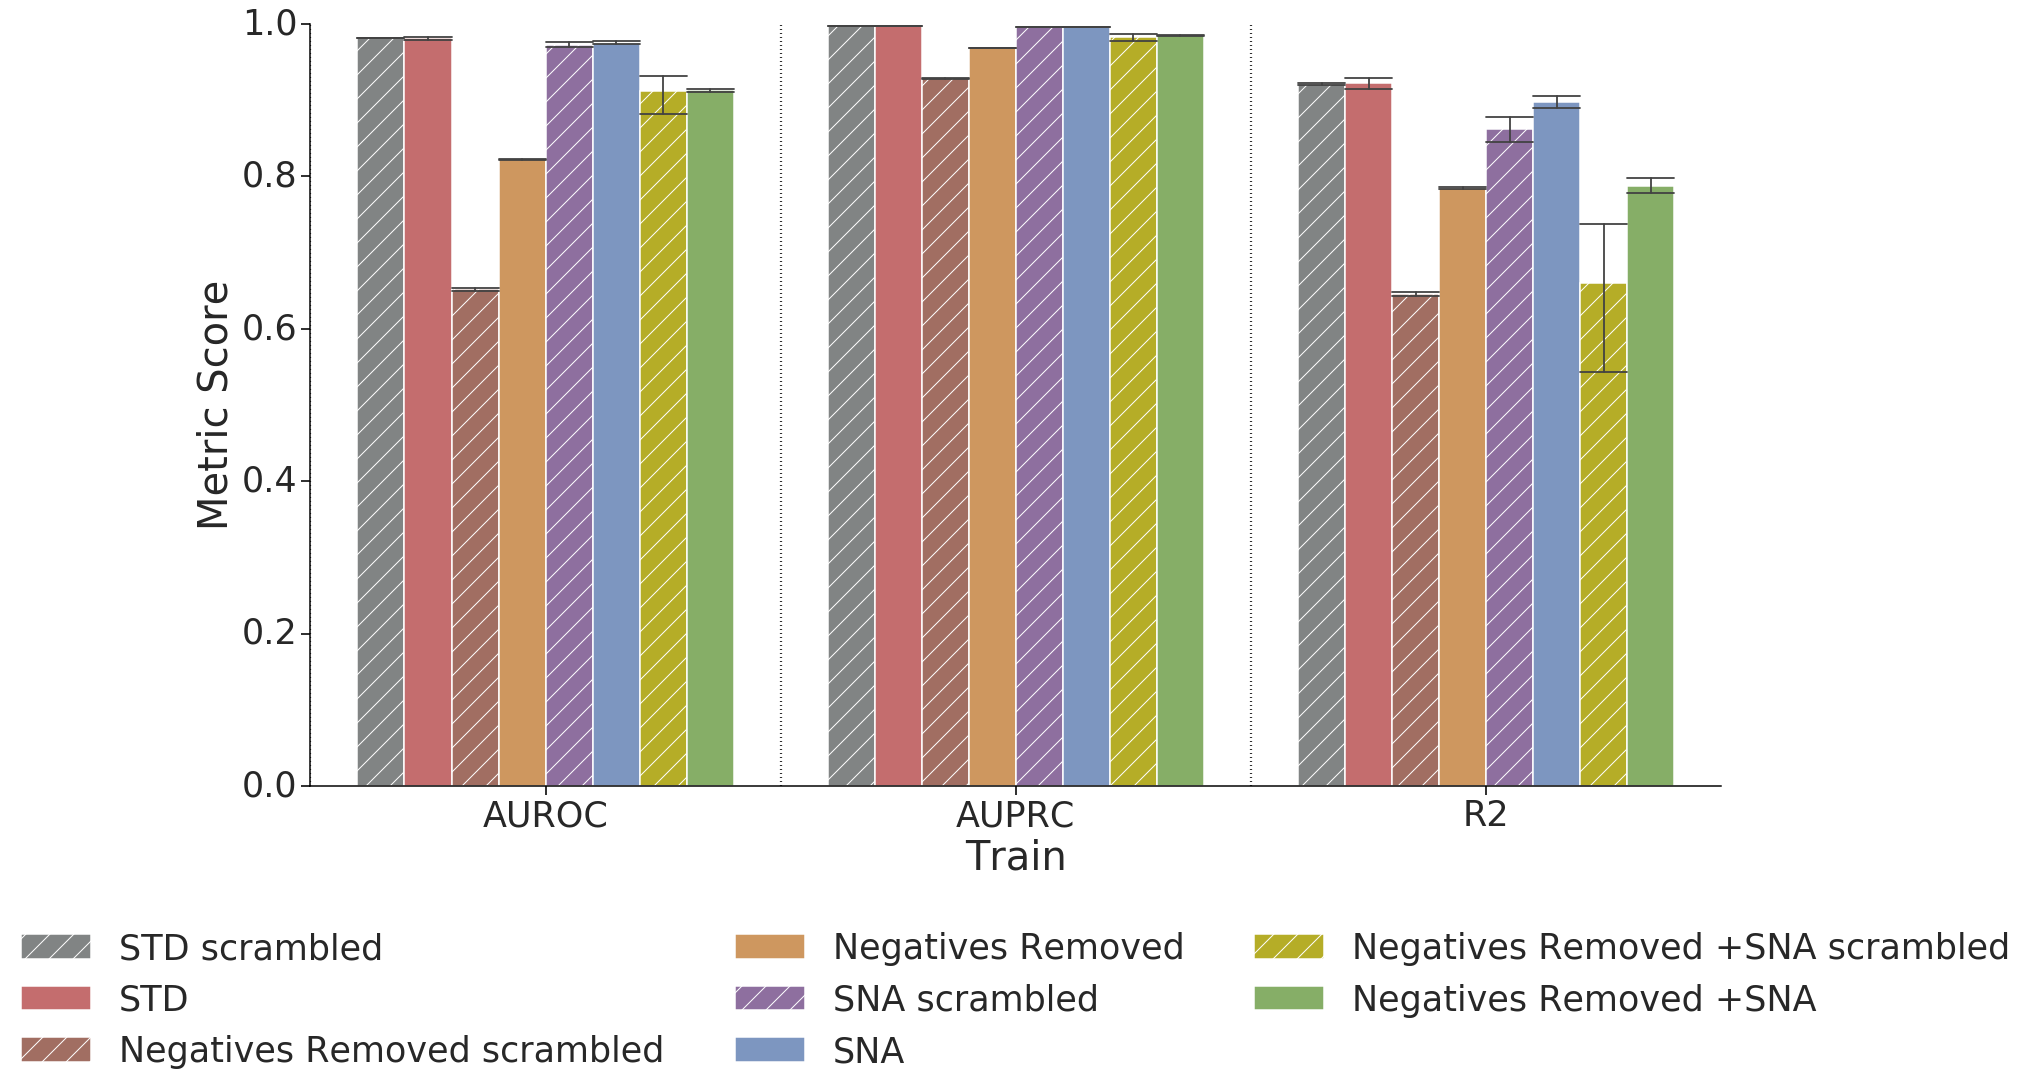

In [22]:
sns.set(style="white")
sns.set_context("talk")
amt = 1.5
expts = ['scrambled_idx_no_SMA_LC', 'STD', 
         'NEG_RM_scrambled', 'NEG_RM', 
         'scrambled_idx_LC', 'STD_SMA', 
         'NEG_RM_RATIOS_scrambled', 'NEG_RM_SMA']

new_df = df.copy()
new_df = rename_vals(new_df, expt_lookup_dict=expt_legend_lookup)

expt_names = [expt_legend_lookup[i] for i in expts]

for dset in new_df.dset.unique():
    
    legend = True
    new_palette= []
    
    for i in expts:
            new_palette.append(color_dict_bar[expt_color_lookup[i]])
            
    tmp_df = new_df[new_df["dset"] == dset].copy()
    tmp_df = tmp_df.pivot_table(columns=["expt", "dset", "fold"]).reset_index()
    tmp_df.columns = ["metric", "expt", "dset", "fold", "value"]
    g = sns.catplot(x="metric", y="value", hue="expt", hue_order=expt_names, data=tmp_df, kind="bar", 
                    palette=new_palette, orient="v", legend=False, legend_out=True, height = 12, aspect=1.75, 
                    **{"capsize":0.1, "errwidth":1.8})

    # set the fancy spines
    (g.despine(right=True)
    .set_xlabels(dset, fontsize=titlesize)
    .set_ylabels("Metric Score")
    .ax.tick_params(top=False, right=False)
    )
    
    g.ax.spines["left"].set_visible(True)
    g.ax.spines["left"].set_color("black")
    g.ax.spines["left"].set_linewidth(1.5)
    g.ax.spines["bottom"].set_visible(True)
    g.ax.spines["bottom"].set_color("black")
    g.ax.spines["bottom"].set_linewidth(1.5)
    g.ax.yaxis.label.set_size(titlesize)
    g.ax.xaxis.label.set_size(titlesize)
#     g.ax.set_ylim(dset_ymin_lookup[dset], 1)
    plt.tick_params(axis='x', which='both', bottom=True, top=False, labelsize=labelsize) 
    plt.tick_params(axis='y', which='both', left=True, right=False, labelsize=labelsize) 
    
    # set the ylim
    line_offset=0
    lower, upper = g.ax.get_xbound()

    for i in np.arange(lower, upper, 1):
        g.ax.axvline(i, ls=":", c=".2")
        
    hatch = [ "/", "/", "/", "", "", "", ]*len(expts)
    leg_artists = []

    for i,thisbar in enumerate(g.ax.patches):
        # Set a different hatch for each bar
        thisbar.set_hatch(hatch[i])
    
    legend = plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3, frameon=False, fontsize=labelsize)  
    
    plt.savefig("{}/{}_STD_SNA_NEGRM_regression_side_barplot_vertical.png".format(save_dir, dset), dpi=100, 
                bbox_extra_artists=[legend,], bbox_inches="tight")
    plt.show()
    plt.clf()

/srv/home/ecaceres/anaconda2/envs/features/lib/python2.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/srv/home/ecaceres/anaconda2/envs/features/lib/python2.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/srv/home/ecaceres/anaconda2/envs/features/lib/python2.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/srv/home/ecaceres/anaconda2/envs/features/lib/pyth

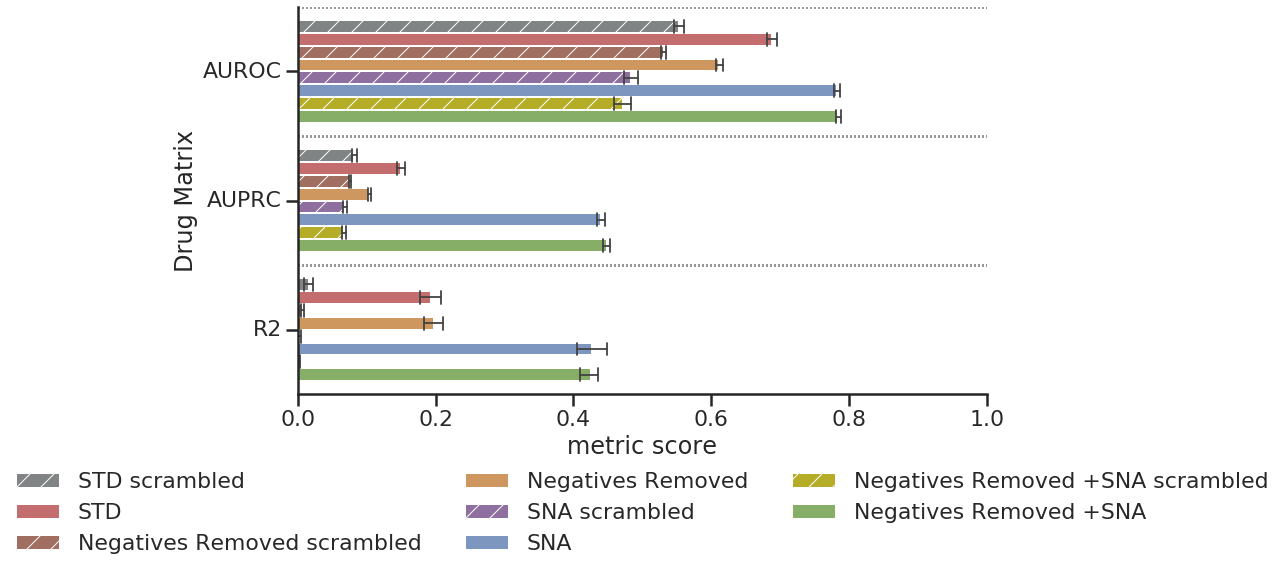

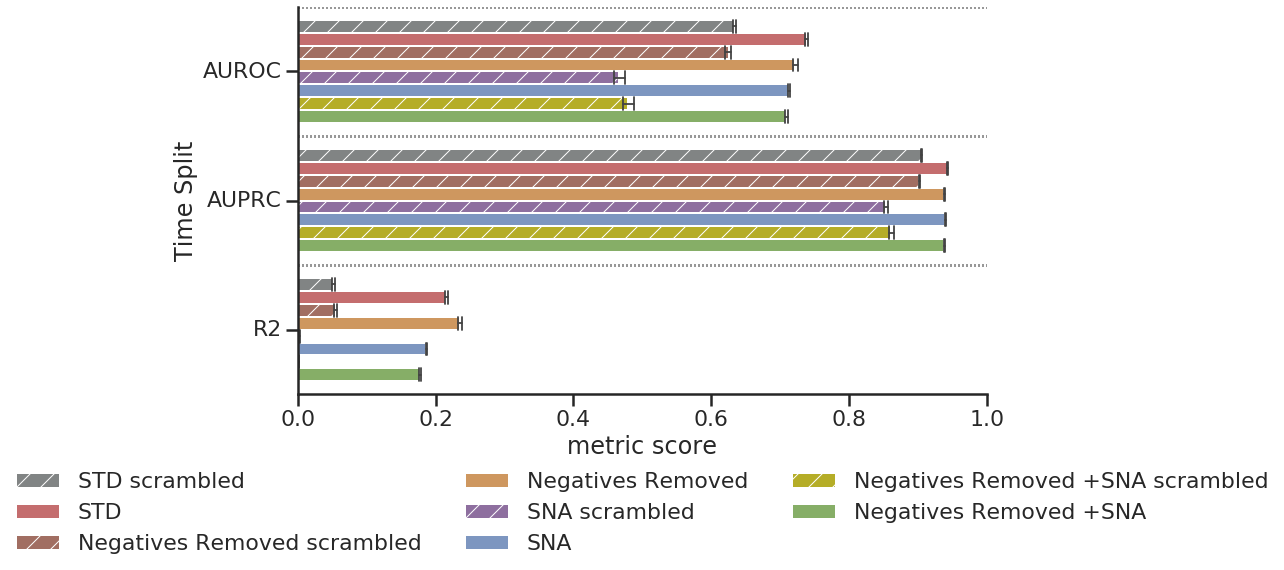

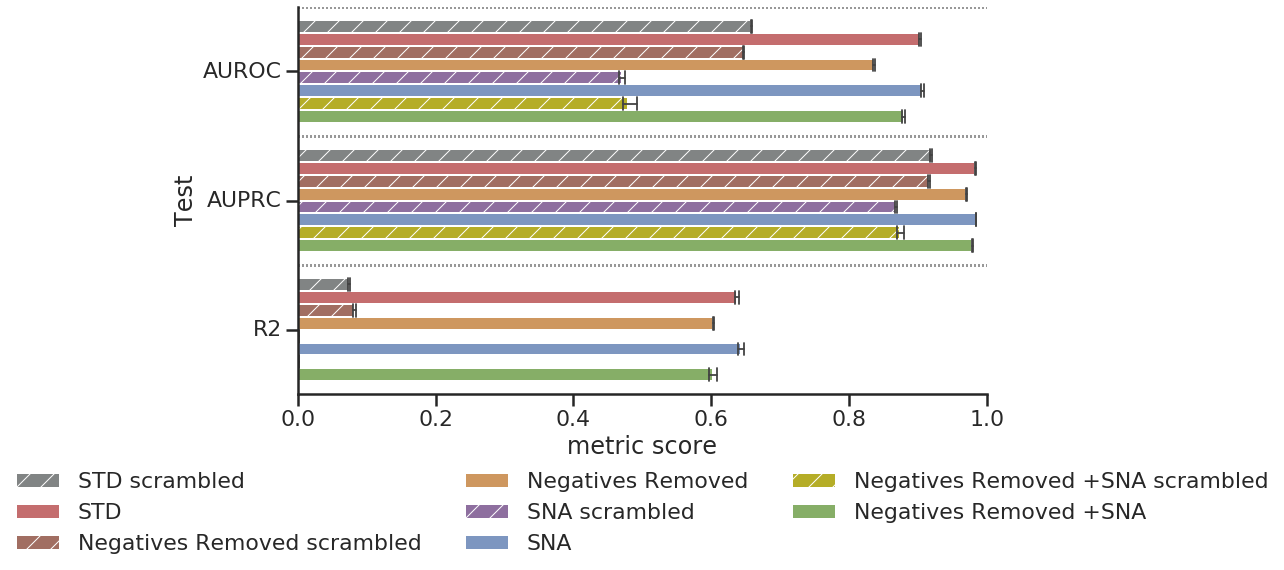

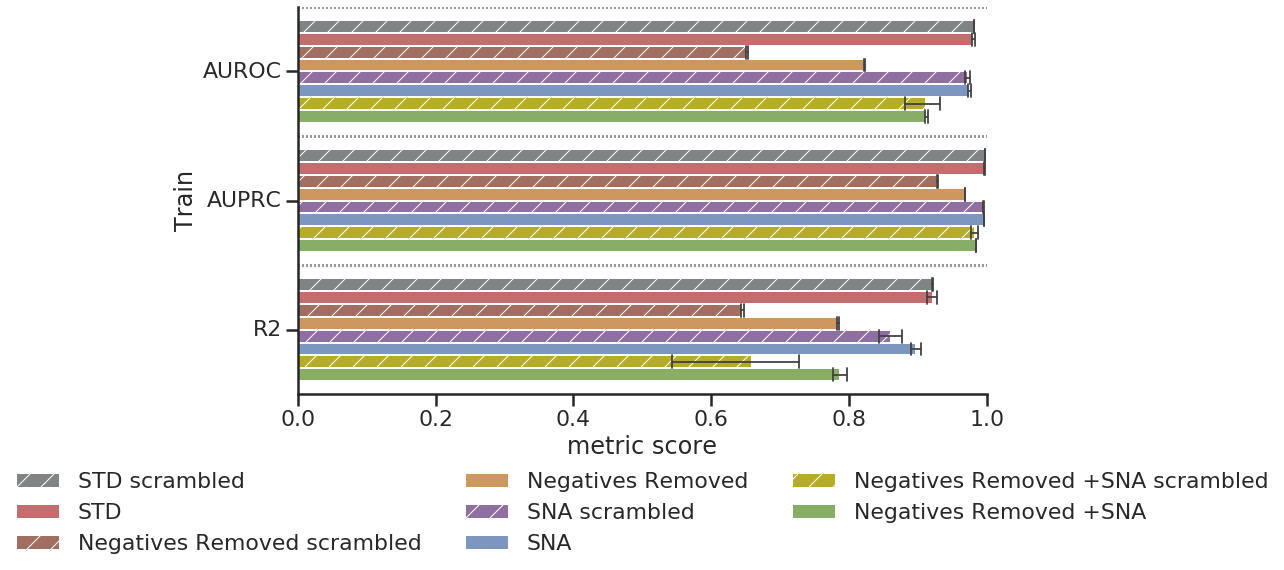

In [36]:
sns.set(style="white")
sns.set_context("poster")
amt = 1.5

expts = ['scrambled_idx_no_SMA_LC', 'STD', 
         'NEG_RM_scrambled', 'NEG_RM', 
         'scrambled_idx_LC', 'STD_SMA', 
         'NEG_RM_RATIOS_scrambled', 'NEG_RM_SMA']

new_palette = [color_dict_bar[expt_color_lookup[i]] for i in expts]

expts = [expt_legend_lookup[i] for i in expts]

for dset in df.dset.unique():
    legend = True
    tmp_df = df[df["dset"] == dset].copy()
    tmp_df = tmp_df.pivot_table(columns=["expt", "dset", "fold"]).reset_index()
    tmp_df.columns = ["metric", "expt", "dset", "fold", "value"]
    tmp_df = rename_vals(tmp_df)
    g = sns.catplot(y="metric", x="value", hue="expt", hue_order=expts, data=tmp_df, kind="bar", 
                    palette=new_palette, orient="h", legend=legend, legend_out=False, height = 7, aspect=1.75, 
                    **{"capsize":0.1, "errwidth":1.8})
    if dset == "drugmatrix":
        name="Drug Matrix"
    elif dset == "timesplit":
        name="Time Split"
    else:
        name = dset.capitalize()
    (g.despine(right=True)
    .set_ylabels(name)
    .set_xlabels("metric score")
    .ax.tick_params(top=False, right=False, )
    )

    g.ax.set_xlim((0,1))
    line_offset=0

    lower, upper = g.ax.get_ybound()
    
    for i in np.arange(lower, upper, 1):
        g.ax.axhline(i, ls=":", c=".2")
    
    hatch = [ "/", "/", "/", "", "", "", ]*len(expts)
    leg_artists = []

    for i,thisbar in enumerate(g.ax.patches):
        # Set a different hatch for each bar
        thisbar.set_hatch(hatch[i])
        
    legend = plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3, frameon=False)    
#     plt.savefig("{}/{}_STD_SNA_NEGRM_regression_side_barplot.png".format(save_dir, dset), dpi=300, 
#                 bbox_extra_artists=[legend,], bbox_inches="tight")
#     plt.clf()
    
    plt.show()

/srv/home/ecaceres/anaconda2/envs/features/lib/python2.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/srv/home/ecaceres/anaconda2/envs/features/lib/python2.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/srv/home/ecaceres/anaconda2/envs/features/lib/python2.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/srv/home/ecaceres/anaconda2/envs/features/lib/pyth

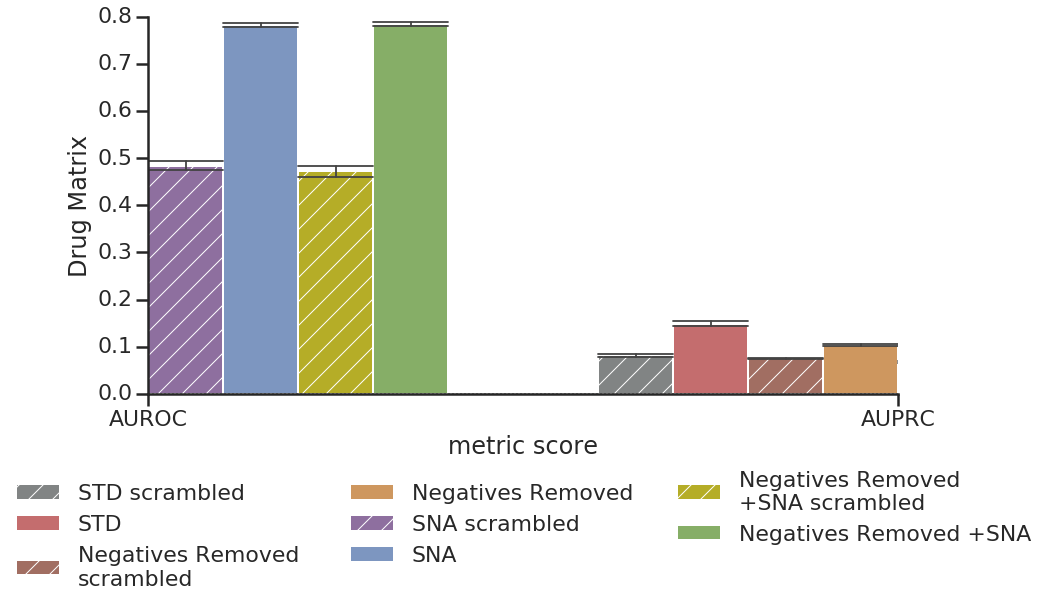

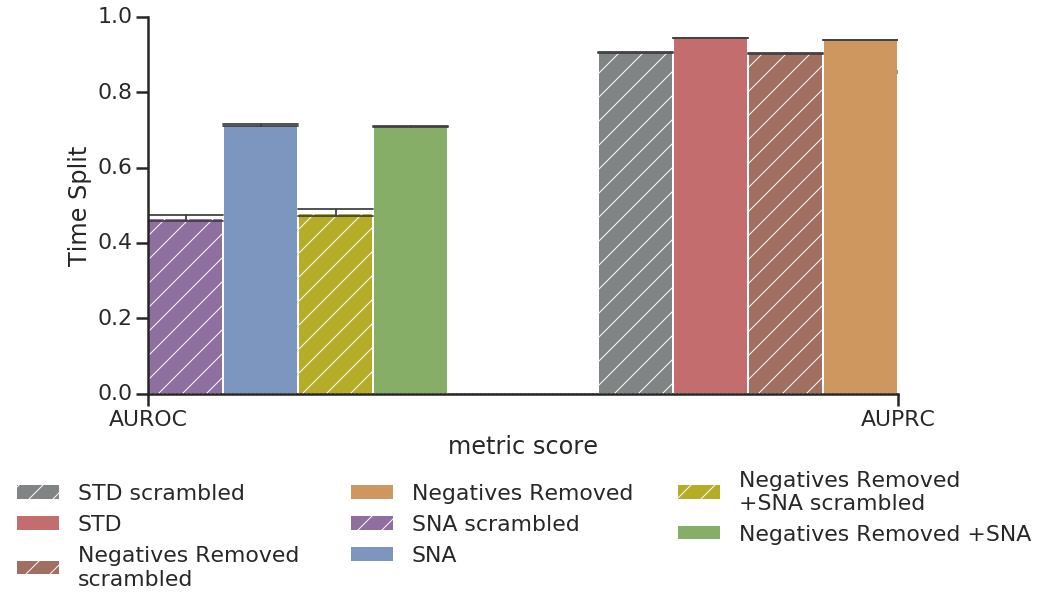

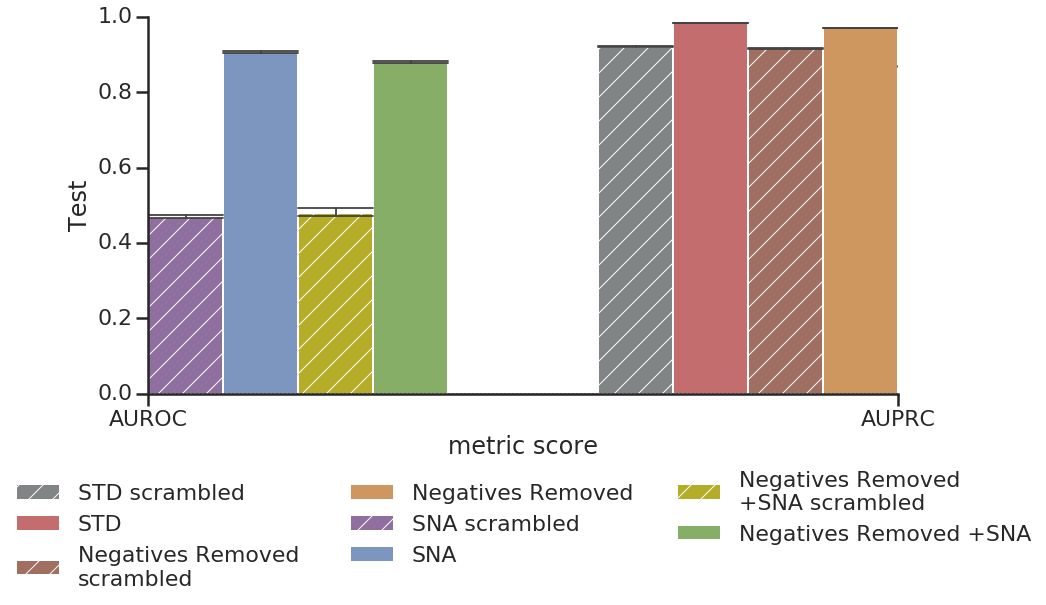

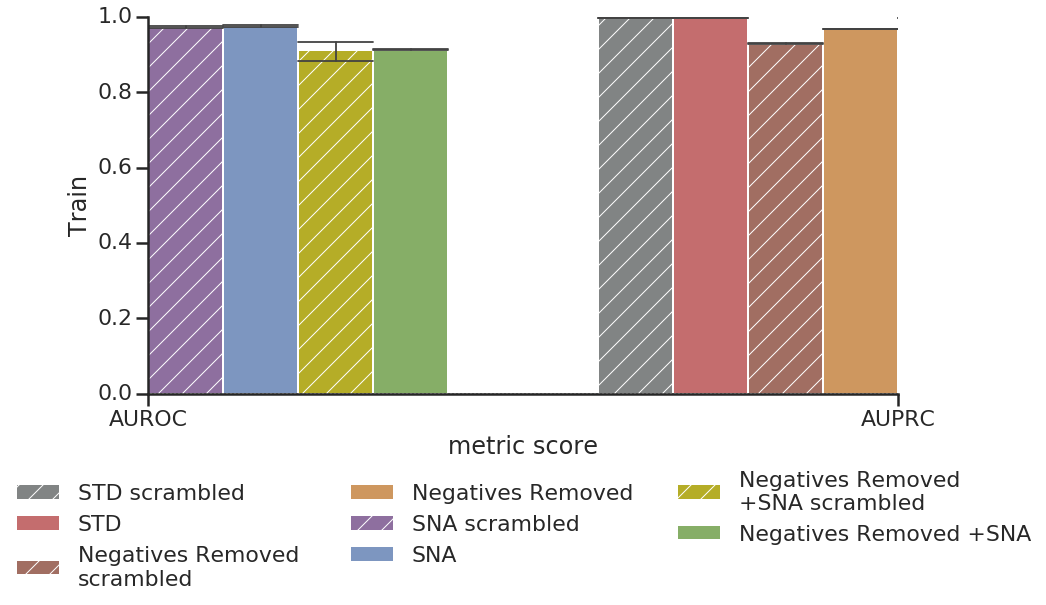

In [25]:
sns.set(style="white")
sns.set_context("poster")
amt = 1.5

expts = ['scrambled_idx_no_SMA_LC', 'STD', 
         'NEG_RM_scrambled', 'NEG_RM', 
         'scrambled_idx_LC', 'STD_SMA', 
         'NEG_RM_RATIOS_scrambled', 'NEG_RM_SMA']

new_palette = [color_dict_bar[expt_color_lookup[i]] for i in expts]

expts = [expt_legend_lookup[i] for i in expts]

for dset in df.dset.unique():
    legend = True
    tmp_df = df[df["dset"] == dset].copy()
    tmp_df = tmp_df.pivot_table(columns=["expt", "dset", "fold"]).reset_index()
    tmp_df.columns = ["metric", "expt", "dset", "fold", "value"]
    tmp_df = rename_vals(tmp_df)
    g = sns.catplot(x="metric", y="value", hue="expt", hue_order=expts, data=tmp_df, kind="bar", 
                    palette=new_palette, orient="v", legend=legend, legend_out=False, height = 7, aspect=1.75,
                    **{"capsize":0.1, "errwidth":1.8})
    if dset == "drugmatrix":
        name="Drug Matrix"
    elif dset == "timesplit":
        name="Time Split"
    else:
        name = dset.capitalize()
    (g.despine(right=True)
    .set_ylabels(name)
    .set_xlabels("metric score")
    .ax.tick_params(top=False, right=False)
    )

    g.ax.set_xlim((0,1))
    line_offset=0

    lower, upper = g.ax.get_ybound()
    
    for i in np.arange(lower, upper, 1):
        g.ax.axhline(i, ls=":", c=".2")
    
    hatch = [ "/", "/", "/", "", "", "", ]*len(expts)
    leg_artists = []

    
    for i,thisbar in enumerate(g.ax.patches):
        # Set a different hatch for each bar
        thisbar.set_hatch(hatch[i])
        
    legend = plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3, frameon=False)    
#     plt.savefig("{}/{}_STD_SNA_NEGRM_regression_side_barplot.png".format(save_dir, dset), dpi=300, 
#                 bbox_extra_artists=[legend,], bbox_inches="tight")
#     plt.clf()
    
    plt.show()

/srv/home/ecaceres/anaconda2/envs/features/lib/python2.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/srv/home/ecaceres/anaconda2/envs/features/lib/python2.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/srv/home/ecaceres/anaconda2/envs/features/lib/python2.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/srv/home/ecaceres/anaconda2/envs/features/lib/pyth

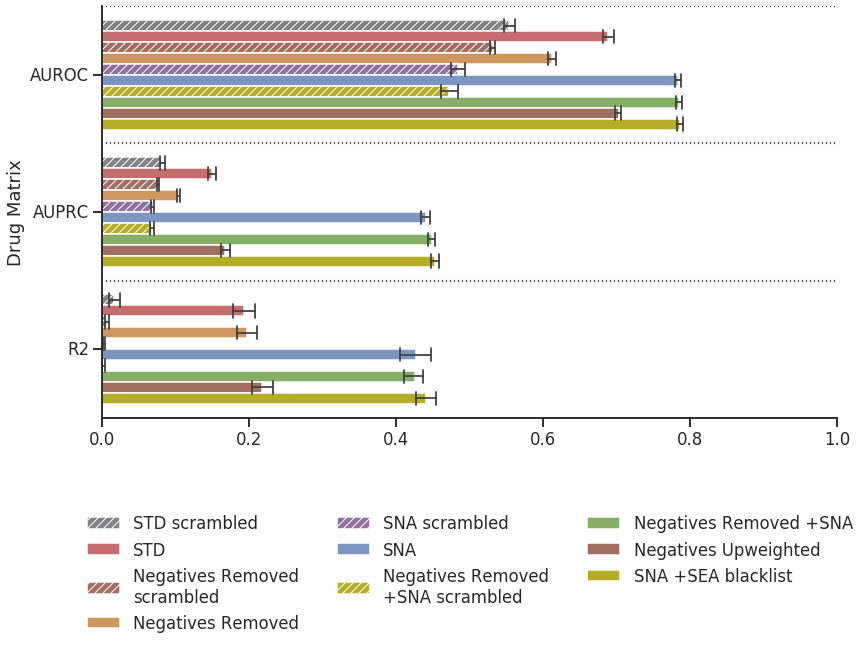

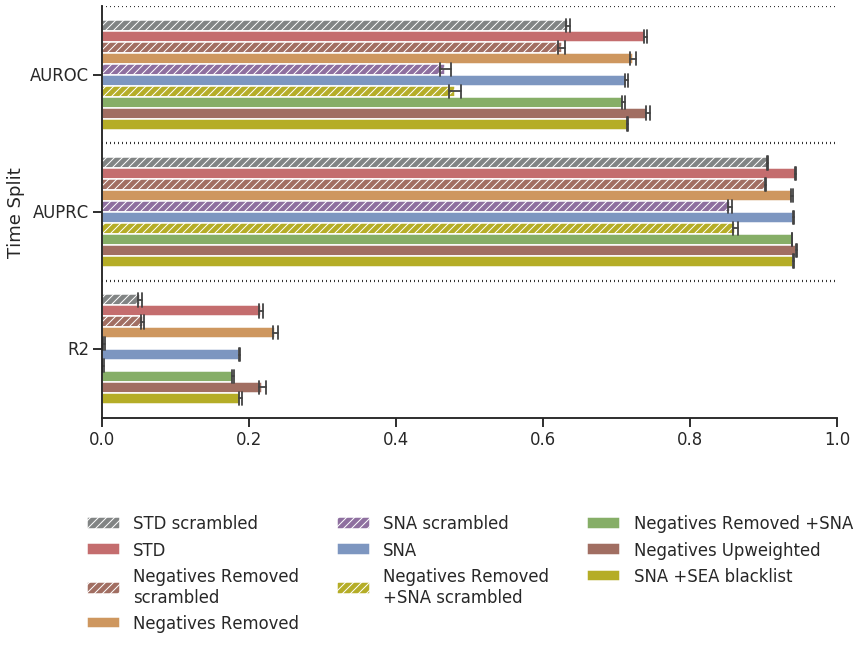

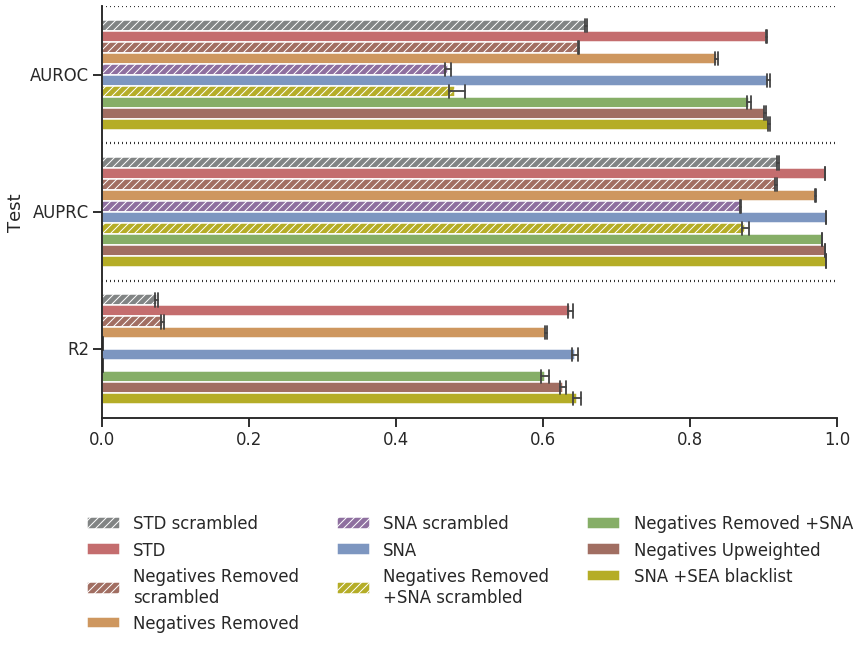

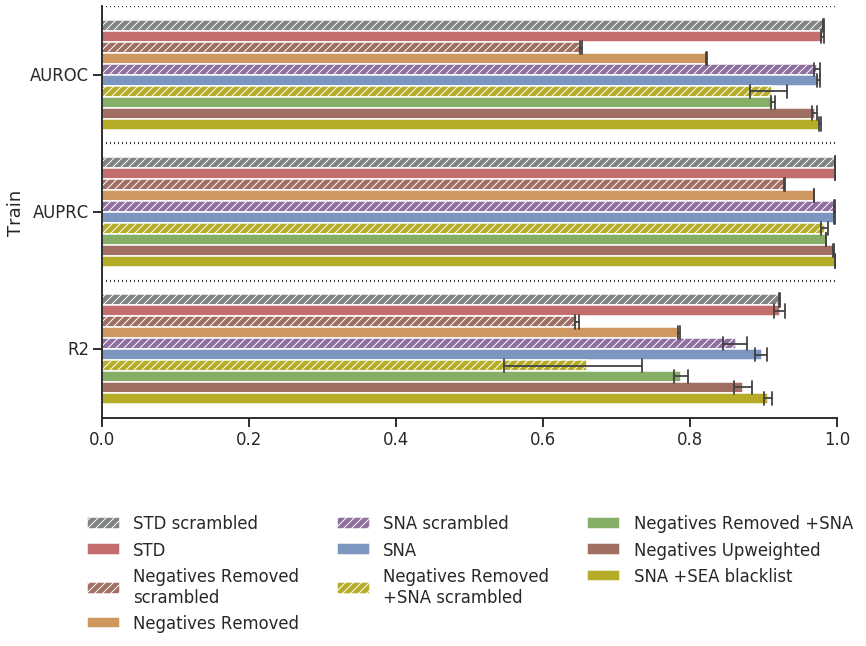

In [18]:
sns.set(style="white")
sns.set_context("talk")
amt = 1.5

expts = ['scrambled_idx_no_SMA_LC', 'STD', 
         'NEG_RM_scrambled', 'NEG_RM', 
         'scrambled_idx_LC', 'STD_SMA', 
         'NEG_RM_RATIOS_scrambled', 'NEG_RM_SMA',
         'NEG_UW', "SEA_SMA"]

new_palette = [color_dict_bar[expt_color_lookup[i]] for i in expts]

expts = [expt_legend_lookup[i] for i in expts]

for dset in df.dset.unique():
    legend = True
    tmp_df = df[df["dset"] == dset].copy()
    tmp_df = tmp_df.pivot_table(columns=["expt", "dset", "fold"]).reset_index()
    tmp_df.columns = ["metric", "expt", "dset", "fold", "value"]
    tmp_df = rename_vals(tmp_df)
    
    g = sns.catplot(y="metric", x="value", hue="expt", hue_order=expts, data=tmp_df, kind="bar", 
                    palette=new_palette, orient="h", legend=legend, legend_out=False, height = 7, aspect=1.75,
                    **{"capsize":0.1, "errwidth":1.8})
    
    (g.despine(right=True)
    .set_ylabels(dset)
    .set_xlabels("")
    .ax.tick_params(top=False, right=False)
    )

    g.ax.set_xlim((0,1))
    line_offset=0

    lower, upper = g.ax.get_ybound()
    
    for i in np.arange(lower, upper, 1):
        g.ax.axhline(i, ls=":", c=".2")
    
    hatch = ["///", "///", "///", "", "", "",
         "///", "///", "///", "", "", "",
         "///", "///", "///", "", "", "", 
         "///", "///", "///", "", "", "",
         "", "", "", "", "", "",]
    
    leg_artists = []

    for i,thisbar in enumerate(g.ax.patches):
        # Set a different hatch for each bar
        thisbar.set_hatch(hatch[i])
        
    legend=plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=3, frameon=False)
    if dset=="drugmatrix":
        ylab = "Drug Matrix"
    elif dset == "timesplit":
        ylab = "Time Split"
    elif dset == "test":
        ylab = "Test"
    elif dset == "train":
        ylab = "Train"
    plt.ylabel(ylab)
    
#     plt.savefig("{}/{}_all_regression_side_barplot.png".format(save_dir, dset), dpi=300, 
#                 bbox_extra_artists=[legend,], bbox_inches="tight")
#     plt.clf()
    plt.show()    
#     handles, labels = g.ax.get_legend_handles_labels()
#     pylab.legend(loc=0,)

/srv/home/ecaceres/anaconda2/envs/features/lib/python2.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/srv/home/ecaceres/anaconda2/envs/features/lib/python2.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/srv/home/ecaceres/anaconda2/envs/features/lib/python2.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/srv/home/ecaceres/anaconda2/envs/features/lib/pyth

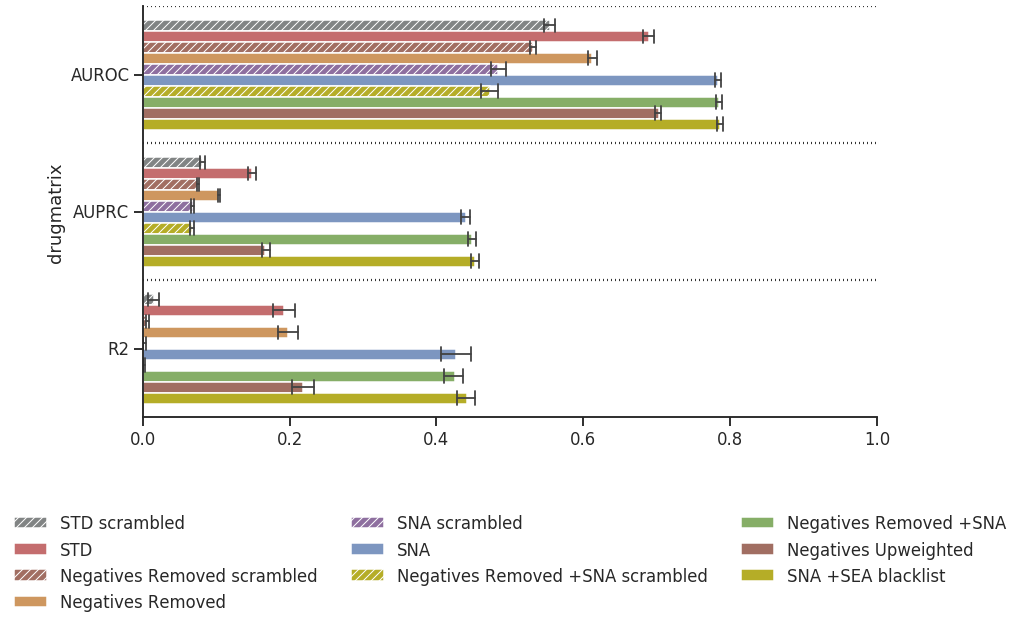

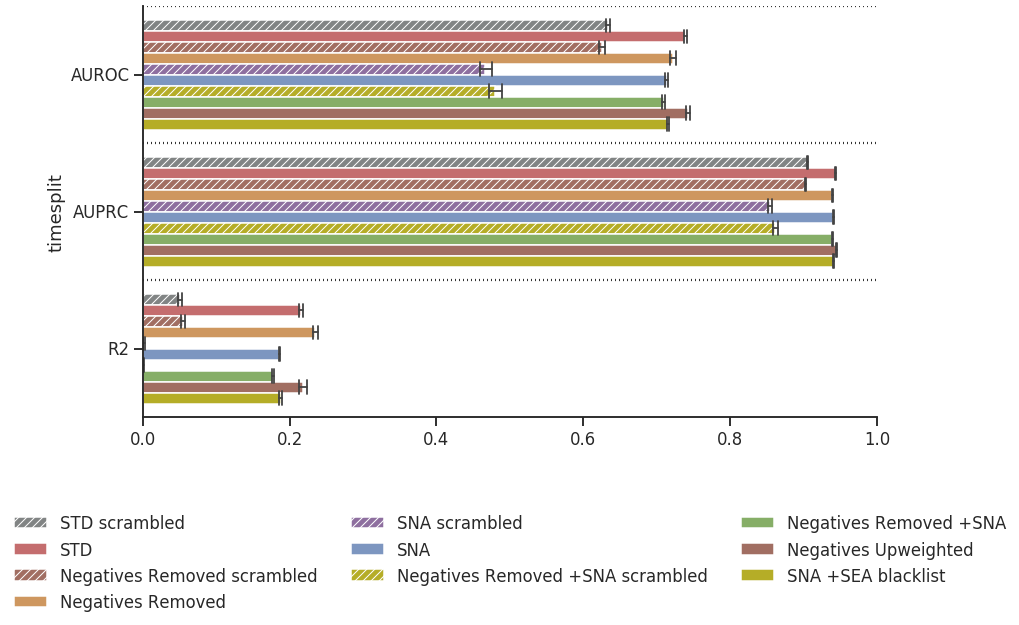

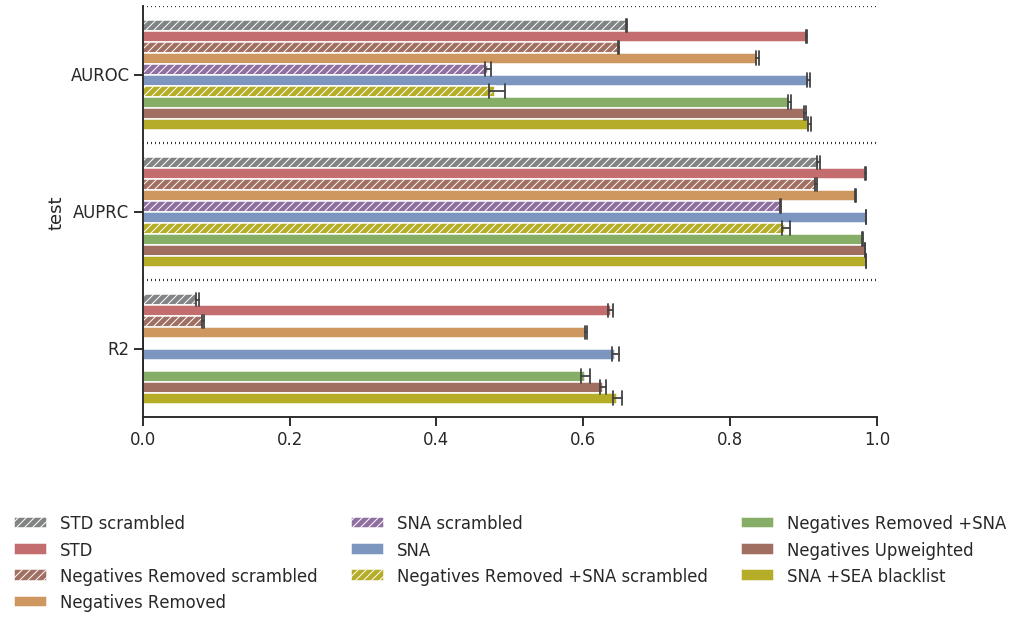

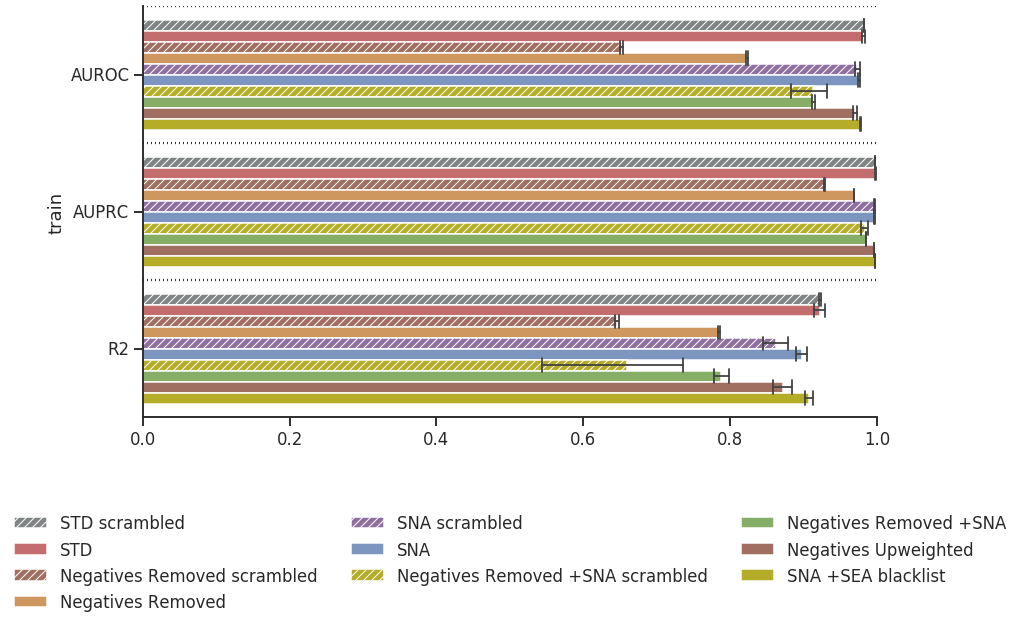

In [19]:
# sns.set(style="white")
# sns.set_context("talk")
# amt = 1.5

# expts = ['scrambled_idx_no_SMA_LC', 'STD', 
#          'NEG_RM_scrambled', 'NEG_RM', 
#          'scrambled_idx_LC', 'STD_SMA', 
#          'NEG_RM_RATIOS_scrambled', 'NEG_RM_SMA',
#          'NEG_UW', "SEA_SMA"]

# new_palette = [color_dict_bar[expt_color_lookup[i]] for i in expts]

# expts = [expt_legend_lookup[i] for i in expts]

# for dset in df.dset.unique():
#     legend = True
#     tmp_df = df[df["dset"] == dset].copy()
#     tmp_df = tmp_df.pivot_table(columns=["expt", "dset", "fold"]).reset_index()
#     tmp_df.columns = ["metric", "expt", "dset", "fold", "value"]
#     tmp_df = rename_vals(tmp_df)
#     g = sns.catplot(y="metric", x="value", hue="expt", hue_order=expts, data=tmp_df, kind="bar", 
#                     palette=new_palette, orient="h", legend=legend, legend_out=False, height = 7, aspect=1.75,
#                     **{"capsize":0.1, "errwidth":1.8})
    
#     (g.despine(right=True)
#     .set_ylabels(dset)
#     .set_xlabels("")
#     .ax.tick_params(top=False, right=False)
#     )

#     g.ax.set_xlim((0,1))
#     line_offset=0

#     lower, upper = g.ax.get_ybound()
    
#     for i in np.arange(lower, upper, 1):
#         g.ax.axhline(i, ls=":", c=".2")
    
#     hatch = ["///", "///", "///", "", "", "",
#          "///", "///", "///", "", "", "",
#          "///", "///", "///", "", "", "", 
#          "///", "///", "///", "", "", "",
#          "", "", "", "", "", "",]
    
#     leg_artists = []

#     for i,thisbar in enumerate(g.ax.patches):
#         # Set a different hatch for each bar
#         thisbar.set_hatch(hatch[i])
    
#     plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=3, frameon=False)
#     plt.show()
# #     handles, labels = g.ax.get_legend_handles_labels()
# #     pylab.legend(loc=0,)